## Xento-Cento Data Set Classification

## Import Libraries

In [1]:
import cv2 #for image reading writing and performing image processing
import audioread
import logging
import os
import random
import time
import warnings
import matplotlib.pyplot as plt #for visualzation
import numpy as np #numerical python
import pandas as pd #reading or writing csv
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
# Librosa Libraries
import librosa
import librosa.display as display
import IPython.display as ipd
#Text Color
from termcolor import colored
from contextlib import contextmanager
from IPython.display import Audio
from pathlib import Path
from typing import Optional, List
from catalyst.dl import SupervisedRunner, State, CallbackOrder, Callback, CheckpointCallback
from fastprogress import progress_bar
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, average_precision_score
import seaborn as sns #modern graphs
sns.set_style("darkgrid")
# Map 1 library
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
plt.style.use("ggplot")
# Map 2 libraries
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import warnings
warnings.filterwarnings('ignore')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
/opt/conda/lib/python3.7/site-packages/tqdm/std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Setting Dataset path for Train and Test Data

In [2]:
path = Path.cwd().parent
input_path = path / "input"
raw_data = input_path / "birdsong-recognition"
train_dir = raw_data / "train_audio"
train_resample_audio_dir = [
  input_path / "birdsong-resampled-train-audio-{:0>2}".format(i)  for i in range(5)
]
test_dir = raw_data / "test_audio"

## Function for Mantaining Log Files

In [3]:
def get_logger(out_file=None):
    logger = logging.getLogger()
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    logger.handlers = []
    logger.setLevel(logging.INFO)

    handler = logging.StreamHandler()
    handler.setFormatter(formatter)
    handler.setLevel(logging.INFO)
    logger.addHandler(handler)

    if out_file is not None:
        fh = logging.FileHandler(out_file)
        fh.setFormatter(formatter)
        fh.setLevel(logging.INFO)
        logger.addHandler(fh)
    logger.info("logger set up")
    return logger

## Function for Calculating Time of a process 

In [4]:
def timer(name: str, logger: Optional[logging.Logger] = None):
    t0 = time.time()
    msg = f"[{name}] start"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if logger is None:
        print(msg)
    else:
        logger.info(msg)

## Loading Train/Test CSV file

In [5]:
train = pd.read_csv(train_resample_audio_dir[0] / "train_mod.csv")

if not test_dir.exists():
    test_dir = input_path / "birdcall-check" / "test_audio"
    test = pd.read_csv(input_path / "birdcall-check" / "test.csv")
else:
    test = pd.read_csv(raw_data / "test.csv")

## Priting first five rows of train dataset along columns

In [6]:
train.head()

rating playback_used ebird_code    channels        date          pitch  \
0     3.5            no     aldfly    1 (mono)  2013-05-25  Not specified   
1     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
2     4.0            no     aldfly  2 (stereo)  2013-05-27           both   
3     3.5            no     aldfly  2 (stereo)  2013-05-27           both   
4     4.0            no     aldfly  2 (stereo)  2013-05-27           both   

   duration      filename          speed           species  ...  \
0        25  XC134874.mp3  Not specified  Alder Flycatcher  ...   
1        36  XC135454.mp3           both  Alder Flycatcher  ...   
2        39  XC135455.mp3           both  Alder Flycatcher  ...   
3        33  XC135456.mp3           both  Alder Flycatcher  ...   
4        36  XC135457.mp3          level  Alder Flycatcher  ...   

             author                       primary_label longitude  \
0  Jonathon Jongsma  Empidonax alnorum_Alder Flycatcher   -92.962   
1       Mike Nelson  Empidonax alnorum_Alder Flycatcher  -82.1106   
2       Mike Nelson  Empidonax alnorum_Alder Flycatcher  -82.1106   
3       Mike Nelson  Empidonax alnorum_Alder Flycatcher  -82.1106   
4       Mike Nelson  Empidonax alnorum_Alder Flycatcher  -82.1106   

          length   time         recordist  \
0  Not specified   8:00  Jonathon Jongsma   
1         0-3(s)  08:30       Mike Nelson   
2         0-3(s)  08:30       Mike Nelson   
3         0-3(s)  08:30       Mike Nelson   
4         0-3(s)  08:30       Mike Nelson   

                                             license resampled_sampling_rate  \
0        Creative Commons Attribution-ShareAlike 3.0                   32000   
1  Creative Commons Attribution-NonCommercial-Sha...                   32000   
2  Creative Commons Attribution-NonCommercial-Sha...                   32000   
3  Creative Commons Attribution-NonCommercial-Sha...                   32000   
4  Creative Commons Attribution-NonCommercial-Sha...                   32000   

  resampled_filename resampled_channels  
0       XC134874.wav           1 (mono)  
1       XC135454.wav           1 (mono)  
2       XC135455.wav           1 (mono)  
3       XC135456.wav           1 (mono)  
4       XC135457.wav           1 (mono)  

[5 rows x 38 columns]

## Exploratory Data Analysis (EDA)

In [7]:
train.describe()

rating      duration          xc_id  resampled_sampling_rate
count  21375.000000  21375.000000   21375.000000                  21375.0
mean       4.068047     55.806784  285004.752140                  32000.0
std        0.988122     76.385696  125160.991016                      0.0
min        0.000000      0.000000    1634.000000                  32000.0
25%        3.500000     15.000000  174094.500000                  32000.0
50%        4.000000     33.000000  293438.000000                  32000.0
75%        5.000000     68.000000  386885.500000                  32000.0
max        5.000000   2283.000000  505611.000000                  32000.0

### The describe() method returns description of the data in the DataFrame. If the DataFrame contains numerical data, the description contains these information for each column: count - The number of not-empty values. mean - The average (mean) value. std - The standard deviation. 
### In our case we have 4 numeric columns inculding rating, duration, xc_id and resampled_sampling_rate.


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21375 entries, 0 to 21374
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   rating                   21375 non-null  float64
 1   playback_used            19575 non-null  object 
 2   ebird_code               21375 non-null  object 
 3   channels                 21375 non-null  object 
 4   date                     21375 non-null  object 
 5   pitch                    21375 non-null  object 
 6   duration                 21375 non-null  int64  
 7   filename                 21375 non-null  object 
 8   speed                    21375 non-null  object 
 9   species                  21375 non-null  object 
 10  number_of_notes          21375 non-null  object 
 11  title                    21375 non-null  object 
 12  secondary_labels         21375 non-null  object 
 13  bird_seen                19575 non-null  object 
 14  sci_name              

### Info method shows index dtype and columns, non-null values and memory usage of dataset.

## Check Null Values

In [9]:
def check_null_values(train):
    # checking missing data
    total = train.isnull().sum().sort_values(ascending = False)
    percent = (train.isnull().sum()/train.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

check_null_values(train).head()

Total    Percent
background      13075  61.169591
description      6199  29.001170
playback_used    1800   8.421053
bird_seen        1800   8.421053
bitrate_of_mp3      8   0.037427

### In above cell we write custom function to check the null values in our dataset including their Percentage w.r.t each column.

## Dataset Size

In [10]:
print(f"Training Dataset Shape: {colored(train.shape, 'yellow')}")


Training Dataset Shape: (21375, 38)


### Our dataset have 21375 rows and 38 columns

## Column-wise Unique Values

In [11]:
print("Data: train")
print("-----------")
for col in train.columns:
    print(col + ":" + colored(str(len(train[col].unique())), 'yellow'))

Data: train
-----------
rating:11
playback_used:3
ebird_code:264
channels:2
date:3522
pitch:5
duration:495
filename:21375
speed:5
species:264
number_of_notes:5
title:21375
secondary_labels:5385
bird_seen:3
sci_name:264
location:6349
latitude:6989
sampling_rate:8
type:1267
elevation:276
description:12695
bitrate_of_mp3:2584
file_type:4
volume:5
background:5518
xc_id:21375
url:21375
country:95
author:949
primary_label:264
longitude:7001
length:5
time:1444
recordist:949
license:4
resampled_sampling_rate:1
resampled_filename:21375
resampled_channels:1


### Above we can see that each column contains how many uniques values in it.

## Value Counts and DIstribution Plot
A good way to understand the distribution of data in a column is by plotting a distribution plot. We write a function plot_distribution which will save us a lot of time.

In [12]:
len(train['primary_label'].value_counts())

264

## Species Type Distribution

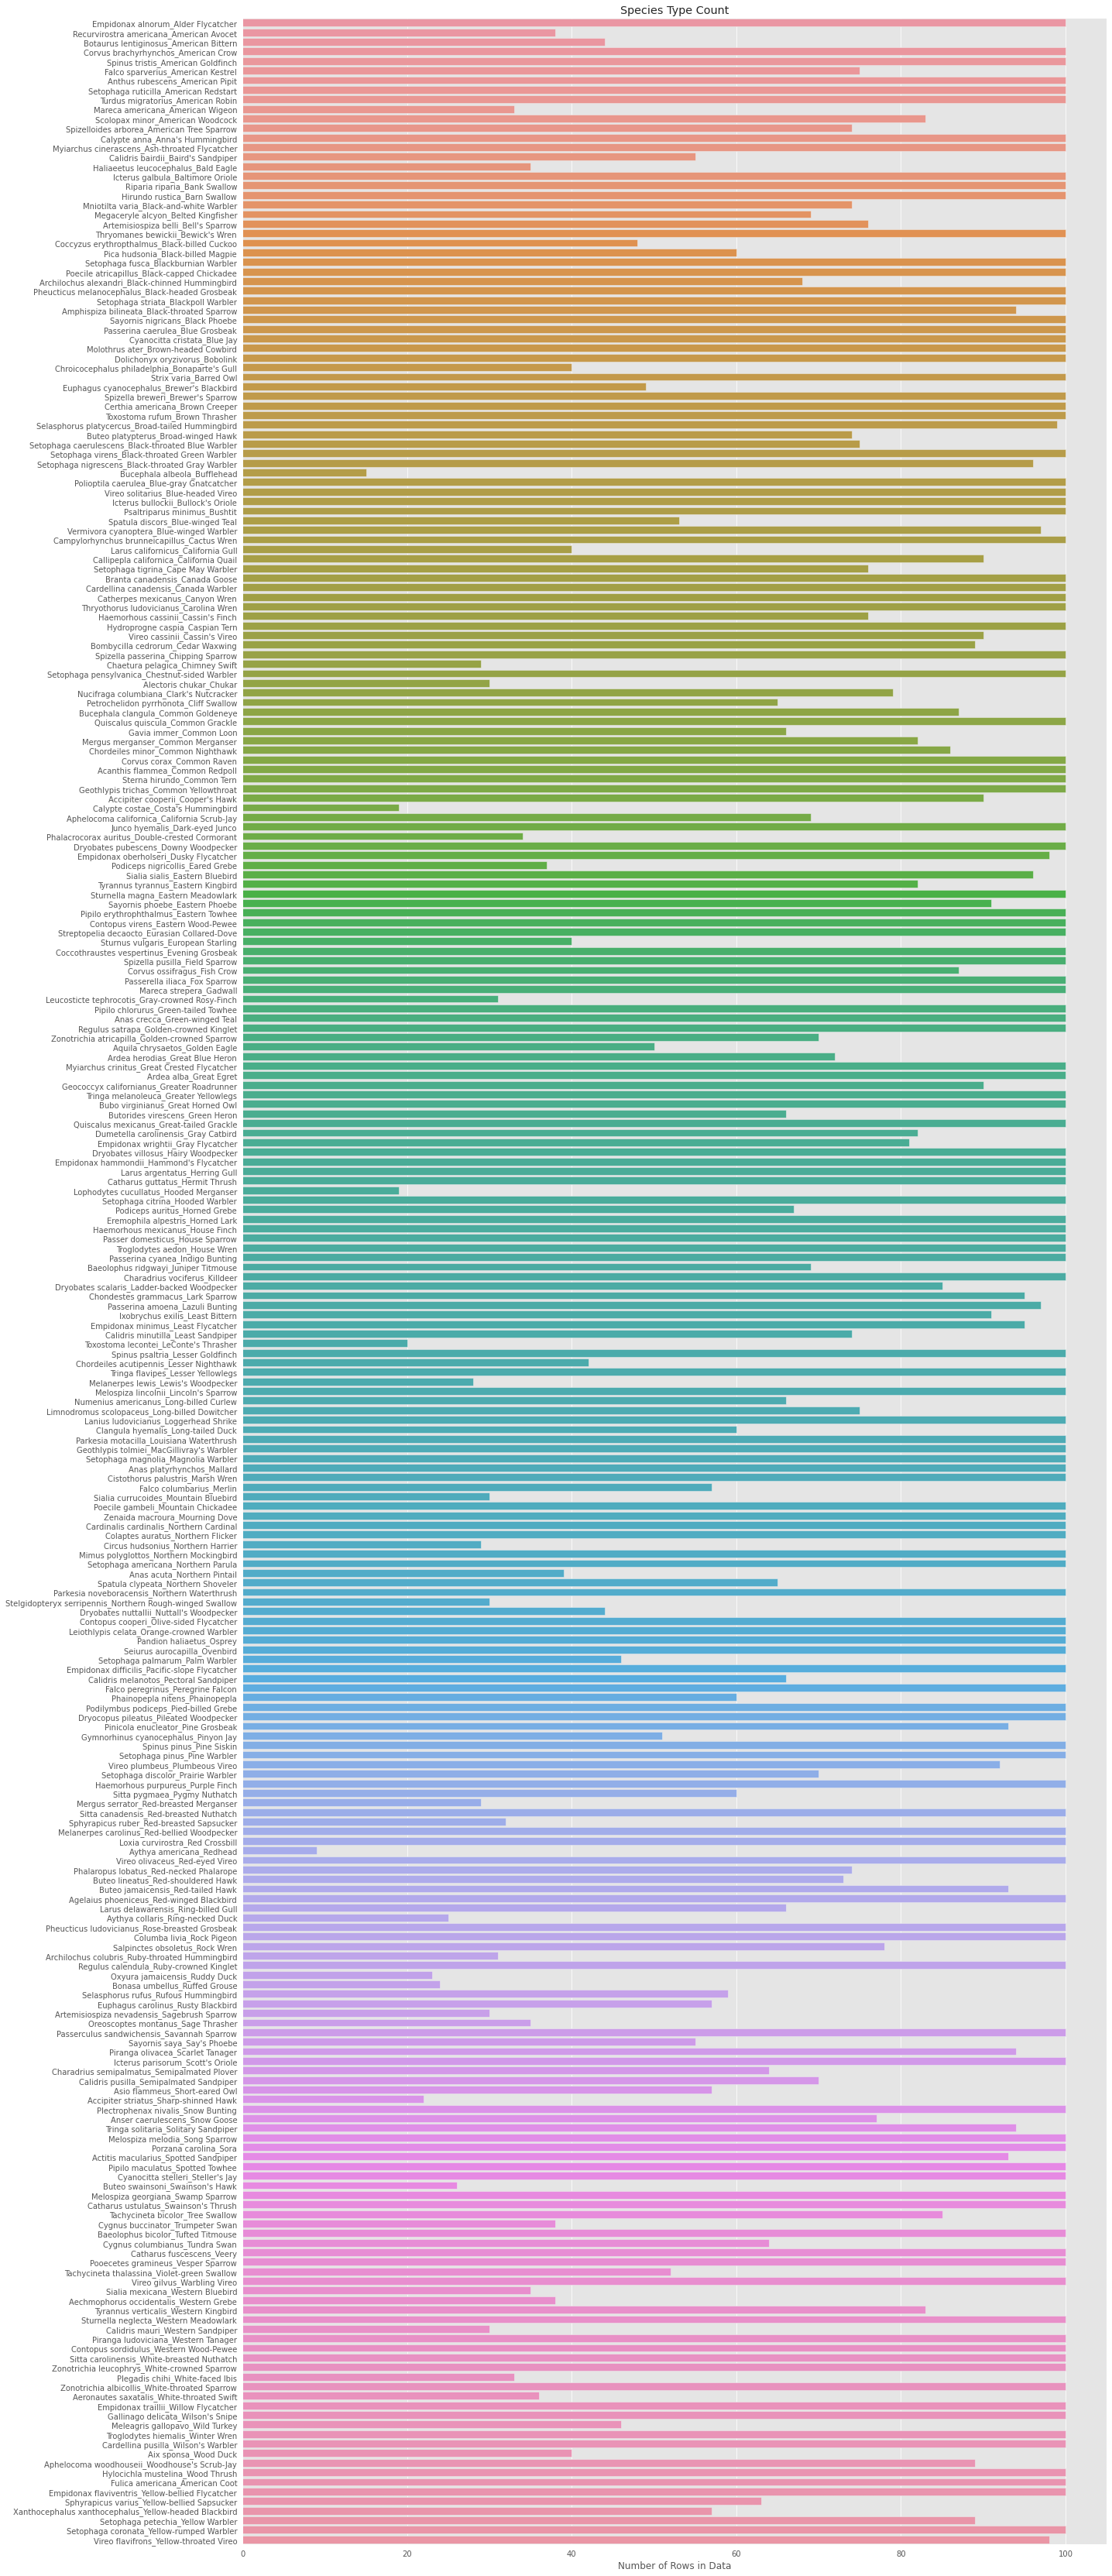

In [15]:
plt.figure(figsize = (20,60))
plt.title('Species Type Count')
sns.countplot(y = 'primary_label', data = train)
plt.xlabel('Number of Rows in Data')
plt.ylabel('')
plt.show()

### In above graph we can see the number of species and thier value counts of each species type

In [16]:
label_list = train.primary_label.value_counts().values, "Primary Label: Count Distribution"

## Rating and Type Exploration

In [17]:
print(f"The Ratings of songs are in range {colored(train.rating.min(), 'yellow')} upto {colored(train.rating.max(), 'yellow')}")

The Ratings of songs are in range 0.0 upto 5.0


Now that we have the range, let's see if we have some great bird singers with us!


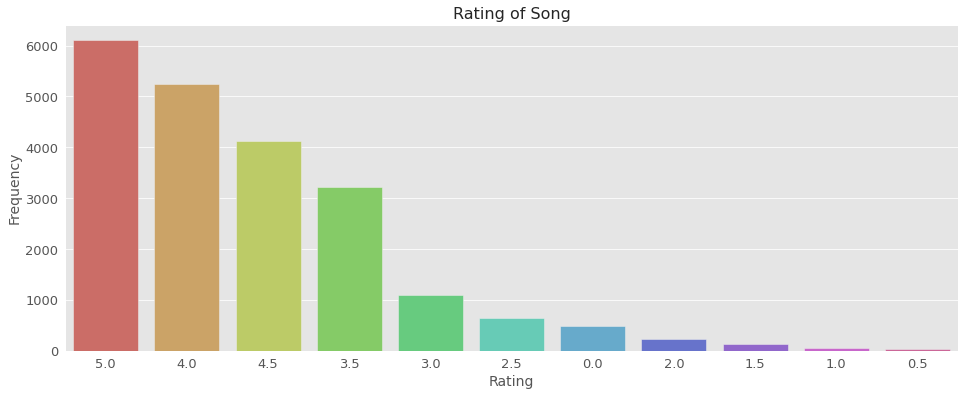

In [18]:

plt.figure(figsize=(16, 6))
ax = sns.countplot(train['rating'], palette="hls", order = train['rating'].value_counts().index)

plt.title("Rating of Song", fontsize = 16)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.ylabel("Frequency", fontsize = 14)
plt.xlabel("Rating", fontsize = 14)
plt.show()

## In above graph we can see the rating distribution w.r.t to frequencies and we can clearly see the most highly rated bird songs have frequency around 6000. Similalry we can notice the trend that higher the frequency will get higher rating vice versa.

# Different Types of Speices of Birds Analysis
We can't directly plot the type column as multiple types are mixed together. One of the examples is shown below.

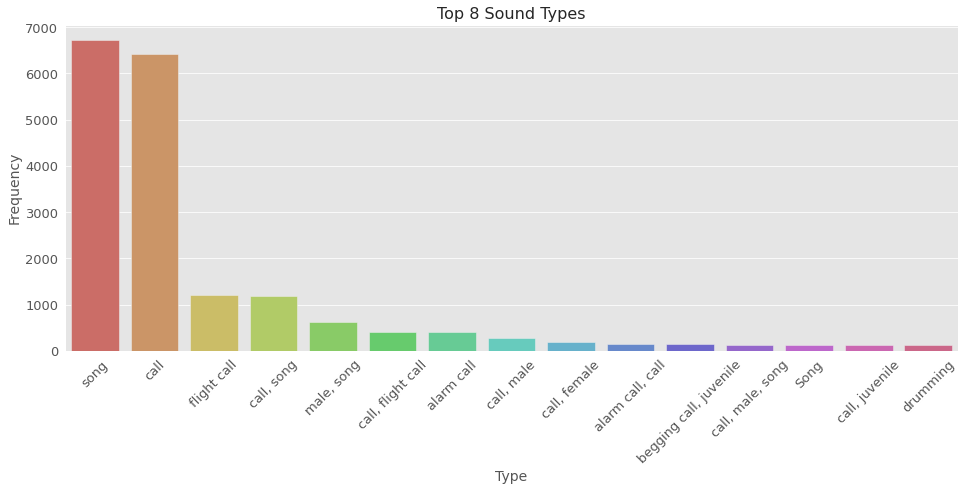

In [19]:
# Create Top 10 list with song types
top_8 = list(train['type'].value_counts().head(15).reset_index()['index'])
data = train[train['type'].isin(top_8)]

plt.figure(figsize=(16, 6))
ax = sns.countplot(data['type'], palette="hls", order = data['type'].value_counts().index)

plt.title("Top 8 Sound Types", fontsize=16)
plt.ylabel("Frequency", fontsize = 14)
plt.yticks(fontsize = 13) 
plt.xticks(rotation = 45, fontsize = 13) 
plt.xlabel("Type", fontsize = 14);

### In above graph we can see the top sound type and their frequencies

# Create some time features

In [20]:
train['year'] = train['date'].apply(lambda x: x.split('-')[0])
train['month'] = train['date'].apply(lambda x: x.split('-')[1])
train['day_of_month'] = train['date'].apply(lambda x: x.split('-')[2])

### We split the date column into three separte columns year, month and day_of_month so we can get more useful insights in EDA

In [21]:
print("There are {:,} unique bird species in the dataset.".format(len(train['species'].unique())))

There are 264 unique bird species in the dataset.


# Droping Ambiguous Date Entries

In [22]:
train['year'] = pd.to_numeric(train['year'])

### Type casting of all columns as all data are in object type so we have to convert into their respective data type as per their nature.  

In [23]:
train.drop(train[train.year <= 1977].index, inplace=True)
train.sort_values('year').head(5)

rating playback_used ebird_code  channels        date          pitch  \
8037      5.0           NaN     eursta  1 (mono)  1979-06-02  Not specified   
15991     4.0           NaN     renpha  1 (mono)  1982-07-14          level   
15992     4.0           NaN     renpha  1 (mono)  1982-07-14          level   
17660     3.5           NaN     snobun  1 (mono)  1982-07-08           both   
6548      4.0           NaN     comred  1 (mono)  1982-11-22  Not specified   

       duration      filename          speed               species  ...  \
8037         24  XC211963.mp3  Not specified       Common Starling  ...   
15991         6   XC25285.mp3          level  Red-necked Phalarope  ...   
15992         8   XC25286.mp3          level  Red-necked Phalarope  ...   
17660        15   XC25167.mp3           both          Snow Bunting  ...   
6548          8   XC25622.mp3   decelerating        Common Redpoll  ...   

              length   time        recordist  \
8037   Not specified  07:30  Mikael Litsgård   
15991         0-3(s)  xx:xx     Niels Krabbe   
15992         0-3(s)  xx:xx     Niels Krabbe   
17660         0-3(s)  xx:xx     Niels Krabbe   
6548          3-6(s)  xx:xx     Niels Krabbe   

                                                 license  \
8037   Creative Commons Attribution-NonCommercial-Sha...   
15991  Creative Commons Attribution-NonCommercial-Sha...   
15992  Creative Commons Attribution-NonCommercial-Sha...   
17660  Creative Commons Attribution-NonCommercial-Sha...   
6548   Creative Commons Attribution-NonCommercial-Sha...   

      resampled_sampling_rate resampled_filename resampled_channels  year  \
8037                    32000       XC211963.wav           1 (mono)  1979   
15991                   32000        XC25285.wav           1 (mono)  1982   
15992                   32000        XC25286.wav           1 (mono)  1982   
17660                   32000        XC25167.wav           1 (mono)  1982   
6548                    32000        XC25622.wav           1 (mono)  1982   

      month day_of_month  
8037     06           02  
15991    07           14  
15992    07           14  
17660    07           08  
6548     11           22  

[5 rows x 41 columns]

### Removing thing data on the base of year which are  insignificant in number and would provide little or no value to the study, were also removed. 

# Time of the Recording

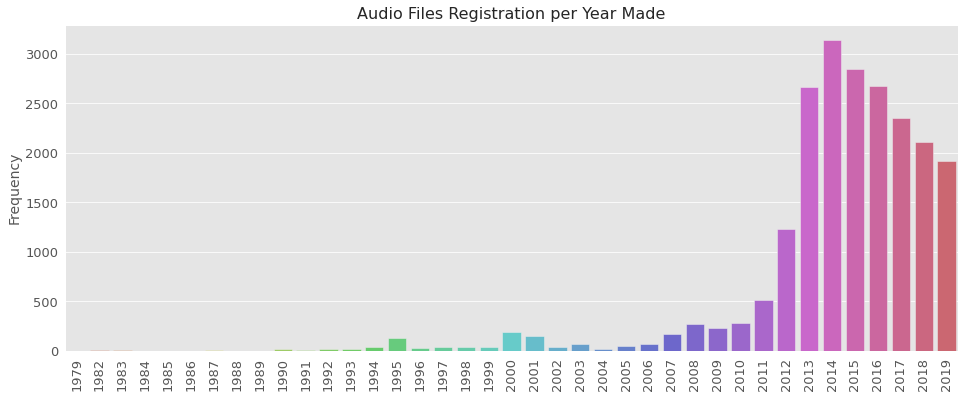

In [24]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(train['year'], palette="hls")
plt.title("Audio Files Registration per Year Made", fontsize=16)
plt.xticks(rotation=90, fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("");

### In above graph we can see that most of recording is recorded in 2014 

## Audio File Registration Per Month Made

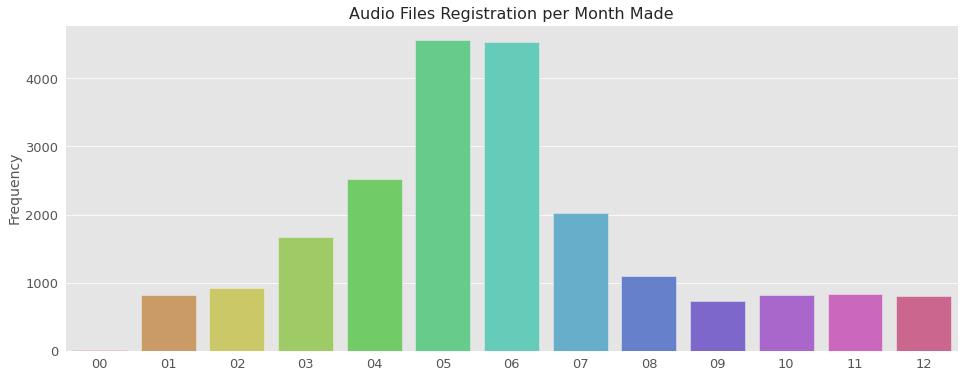

In [25]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(train['month'], palette="hls")
plt.title("Audio Files Registration per Month Made", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("");

### In above graph we can see the recording of birds sounds w.r.t months and found that in month of may and june most of recordings are recorded

# The Songs
We must be careful in how we interpret this column because it is one of the more erratic ones. Call, song, and flight are the most common song types.

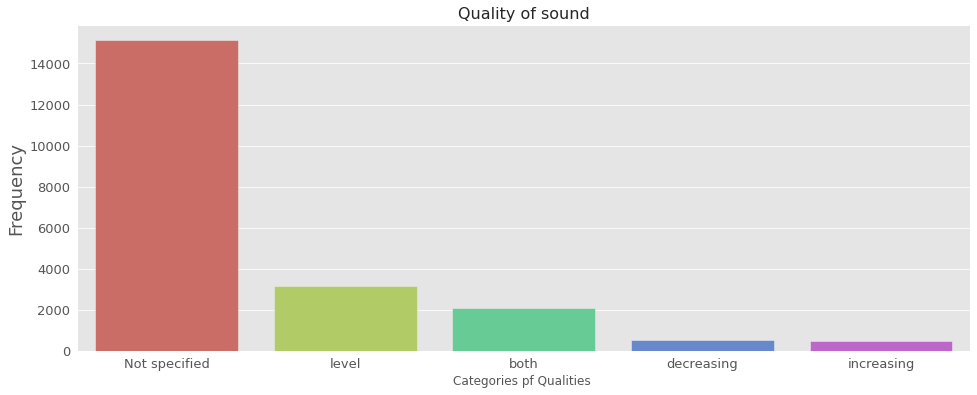

In [26]:
plt.figure(figsize=(16, 6))
ax = sns.countplot(train['pitch'], palette="hls", order = train['pitch'].value_counts().index)

plt.title("Quality of sound", fontsize=16)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylabel("Frequency", fontsize=18)
plt.xlabel("Categories pf Qualities ");

### from this bar chart we categories the quality of sound and found that most of them are not specified

# Loading and Visualizing an audio file

## Duration and Audio File Types 

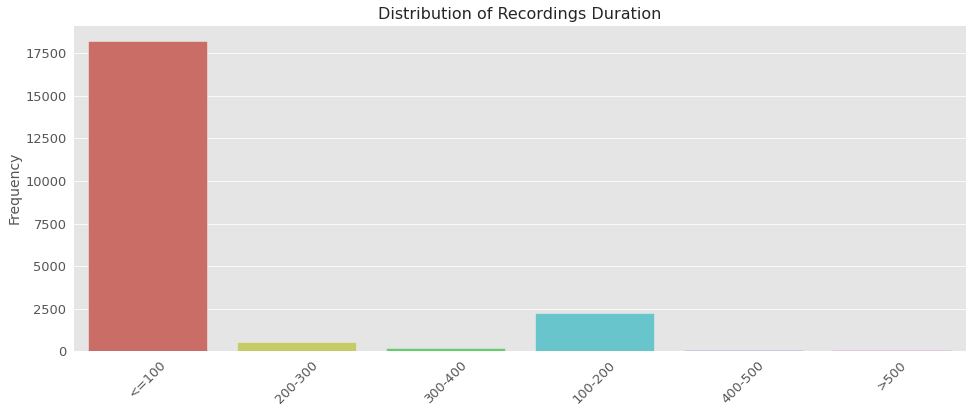

In [27]:
# Creating Interval for *duration* variable
train['duration_interval'] = ">500"
train.loc[train['duration'] <= 100, 'duration_interval'] = "<=100"
train.loc[(train['duration'] > 100) & (train['duration'] <= 200), 'duration_interval'] = "100-200"
train.loc[(train['duration'] > 200) & (train['duration'] <= 300), 'duration_interval'] = "200-300"
train.loc[(train['duration'] > 300) & (train['duration'] <= 400), 'duration_interval'] = "300-400"
train.loc[(train['duration'] > 400) & (train['duration'] <= 500), 'duration_interval'] = "400-500"



plt.figure(figsize=(16, 6))
ax = sns.countplot(train['duration_interval'], palette="hls")

plt.title("Distribution of Recordings Duration", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.yticks(fontsize=13)
plt.xticks(rotation=45, fontsize=13)
plt.xlabel("");

### From above graph, we can conculde that most of the recording are less or equal than 100 seconds

## Sampling rate
Sampling rate (audio) Sampling rate or sampling frequency defines the number of samples per second.

In [28]:
rec = train.sampling_rate.value_counts()
fig = go.Figure(data=[
    go.Bar(x=rec.index, y=rec.values,marker_color='deeppink')
])

fig.update_layout(title='Top Recordists')
fig.show()

### From above interactive graph we can see that most of recordings are from 44100Hz to 48000Hz

# Bird Species


In [29]:
print("There are {} unique species of birds in train dataset".format(train.species.nunique()))

There are 264 unique species of birds in train dataset


In [30]:
species=train.species.value_counts()
fig = go.Figure(data=[
    go.Bar(y=species.values, x=species.index,marker_color='deeppink')
])

fig.update_layout(title='Distribution of Bird Species')
fig.show()

### From above bird distrution species we can see that most frequent specie is Sand Martin

# Country:
Country in which the observation is made


In [31]:
country = train.country.value_counts()[:20]
fig = go.Figure(data=[
    go.Bar(x=country.index, y=country.values,marker_color='deeppink')
])

fig.update_layout(title='Countries from which data is obtained')
fig.show()

### From above graph, we can see the top list of countries with most recording and USA is the on top with most number of recording

# Duration:
Duration of the observation


In [32]:
hist_data = train.duration.values.tolist()
fig = go.Figure(data=[go.Histogram(x=hist_data,marker_color='deeppink')])
fig.update_layout(title='Duration of the observation')

fig.show()

### From above histogram, we can noticed that the most of durations are started deom 0 to 200 as trends show in histogram most values counts found in this range

# Geographical Analysis of the Birds:

In [33]:
df=train.groupby(['latitude','longitude'],as_index=False)['ebird_code'].agg('count')

In [34]:
df=df[df.latitude!='Not specified']
fig = go.Figure()
fig.add_trace(go.Scattergeo(
        lon = df['longitude'],
        lat = df['latitude'],
        text = df['ebird_code'],
        marker = dict(
            size = df['ebird_code'],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        )))


fig.update_layout(
        title_text = 'Bird Samples collected From Parts of World',
        showlegend = True,
        geo = dict(
            landcolor = 'rgb(217, 217, 217)',
        )
    )

fig.show()

### From above geographical, we can see that from which part of world recorded most voices we can intract with geographical map by hovering mouse curser

# Some Samples of Recordings

In [35]:
# Create Full Path so we can access data more easily
base_dir = '../input/birdsong-recognition/train_audio/'
train['full_path'] = base_dir + train['ebird_code'] + '/' + train['filename']

# Now let's sample a fiew audio files
amered = train[train['ebird_code'] == "amered"].sample(1, random_state = 22)['full_path'].values[0]
cangoo = train[train['ebird_code'] == "cangoo"].sample(1, random_state = 22)['full_path'].values[0]
haiwoo = train[train['ebird_code'] == "haiwoo"].sample(1, random_state = 22)['full_path'].values[0]
pingro = train[train['ebird_code'] == "pingro"].sample(1, random_state = 22)['full_path'].values[0]
vesspa = train[train['ebird_code'] == "vesspa"].sample(1, random_state = 22)['full_path'].values[0]

bird_sample_list = ["amered", "cangoo", "haiwoo", "pingro", "vesspa"]

In [36]:
# Amered
ipd.Audio(amered)

### Above is the sample voice of amered

In [37]:
# Vesspa
ipd.Audio(vesspa)

### Above is the sample voice of vesspa

# Features Extracting from Birds Voice   
The audio data is composed by:
  1. Sound
  2. Sample Rate


In [38]:
# Importing 1 file
y, sr = librosa.load(vesspa)

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(y)[0]/sr)

y: [0. 0. 0. ... 0. 0. 0.] 

y shape: (2364480,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 107.2326530612245


### we load the voice sample of vesspa and printed the shape of audio and sample rate also the length of audio

## Trim leading and trailing silence from an audio signal (silence before and after the actual audio)

In [39]:
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [0. 0. 0. ... 0. 0. 0.] 

Audio File shape: (2364480,)


In [40]:
# Importing the 5 files
y_amered, sr_amered = librosa.load(amered)
audio_amered, _ = librosa.effects.trim(y_amered)

y_cangoo, sr_cangoo = librosa.load(cangoo)
audio_cangoo, _ = librosa.effects.trim(y_cangoo)

y_haiwoo, sr_haiwoo = librosa.load(haiwoo)
audio_haiwoo, _ = librosa.effects.trim(y_haiwoo)

y_pingro, sr_pingro = librosa.load(pingro)
audio_pingro, _ = librosa.effects.trim(y_pingro)

y_vesspa, sr_vesspa = librosa.load(vesspa)
audio_vesspa, _ = librosa.effects.trim(y_vesspa)

### Above we load sound of amered, cangoo, haiwoo, pingro and vesspa and trim them

# Graphical Representation of Birds sounds Waves

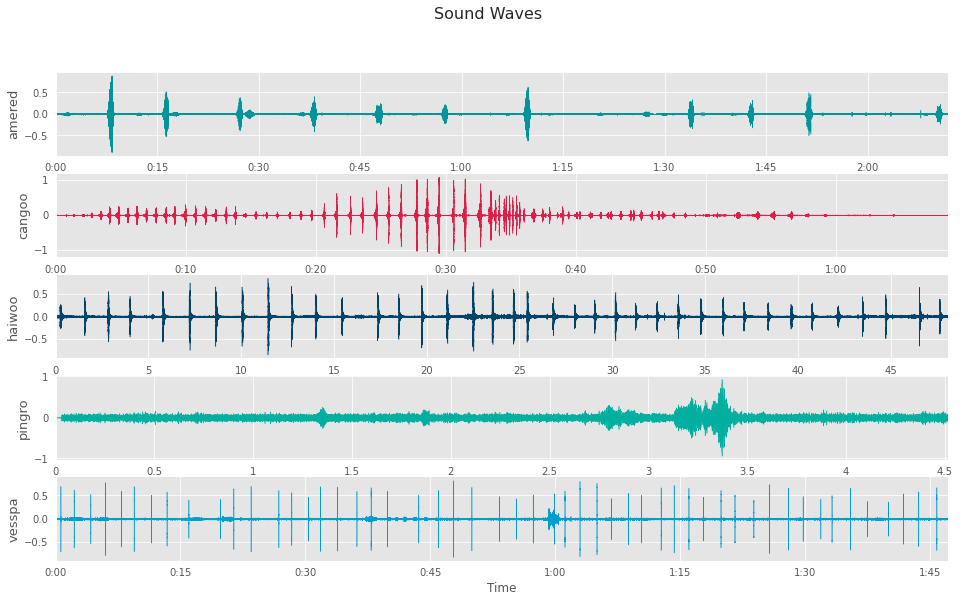

In [41]:
fig, ax = plt.subplots(5, figsize = (16, 9))
fig.suptitle('Sound Waves', fontsize=16)

librosa.display.waveplot(y = audio_amered, sr = sr_amered, color = "#01949A", ax=ax[0])
librosa.display.waveplot(y = audio_cangoo, sr = sr_cangoo, color = "#DB1F48", ax=ax[1])
librosa.display.waveplot(y = audio_haiwoo, sr = sr_haiwoo, color = "#004369", ax=ax[2])
librosa.display.waveplot(y = audio_pingro, sr = sr_pingro, color = "#00AFA0", ax=ax[3])
librosa.display.waveplot(y = audio_vesspa, sr = sr_vesspa, color = "#009DCF", ax=ax[4]);

for i, name in zip(range(5), bird_sample_list):
    ax[i].set_ylabel(name, fontsize=13)

# Applying Fourier Transform to Smoother the Sound Waves
Function that takes an input signal in the time domain and produces the signal's frequency breakdown. Both the y-axis (frequency) and the "colour" axis (amplitude), which approximates the log scale of amplitudes, should be transformed to the log scale.

In [42]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D_amered = np.abs(librosa.stft(audio_amered, n_fft = n_fft, hop_length = hop_length))
D_cangoo = np.abs(librosa.stft(audio_cangoo, n_fft = n_fft, hop_length = hop_length))
D_haiwoo = np.abs(librosa.stft(audio_haiwoo, n_fft = n_fft, hop_length = hop_length))
D_pingro = np.abs(librosa.stft(audio_pingro, n_fft = n_fft, hop_length = hop_length))
D_vesspa = np.abs(librosa.stft(audio_vesspa, n_fft = n_fft, hop_length = hop_length))

In [43]:
print('Shape of amered object:', np.shape(D_amered))
print('Shape of cangoo object:', np.shape(D_cangoo))
print('Shape of haiwoo object:', np.shape(D_haiwoo))
print('Shape of pingro object:', np.shape(D_pingro))
print('Shape of vesspa object:', np.shape(D_vesspa))


Shape of amered object: (1025, 5683)
Shape of cangoo object: (1025, 2957)
Shape of haiwoo object: (1025, 2073)
Shape of pingro object: (1025, 195)
Shape of vesspa object: (1025, 4619)


# Convert Sound Voices an amplitude spectrogram

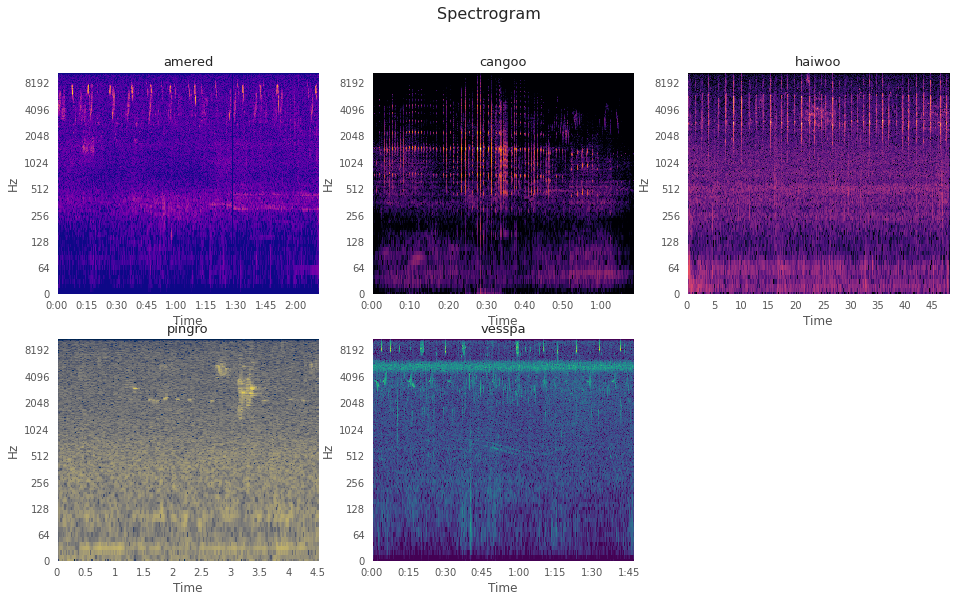

In [44]:
DB_amered = librosa.amplitude_to_db(D_amered, ref = np.max)
DB_cangoo = librosa.amplitude_to_db(D_cangoo, ref = np.max)
DB_haiwoo = librosa.amplitude_to_db(D_haiwoo, ref = np.max)
DB_pingro = librosa.amplitude_to_db(D_pingro, ref = np.max)
DB_vesspa = librosa.amplitude_to_db(D_vesspa, ref = np.max)

# === PLOT ===
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Spectrogram', fontsize=16)
fig.delaxes(ax[1, 2])

librosa.display.specshow(DB_amered, sr = sr_amered, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'plasma', ax=ax[0, 0])
librosa.display.specshow(DB_cangoo, sr = sr_cangoo, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'inferno', ax=ax[0, 1])
librosa.display.specshow(DB_haiwoo, sr = sr_haiwoo, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'magma', ax=ax[0, 2])
librosa.display.specshow(DB_pingro, sr = sr_pingro, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cividis', ax=ax[1, 0])
librosa.display.specshow(DB_vesspa, sr = sr_vesspa, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'viridis', ax=ax[1, 1]);

for i, name in zip(range(0, 2*3), bird_sample_list):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13) 

### From above 5 images we can see the spectogram of all choosed 5 bird species and can noticed that there frequencies have different patterns with passage of time such as vesspa have high frequency while cangoo have different patterbs

## Mel Spectrogram: Sounds Frequencies are converted to the mel scale

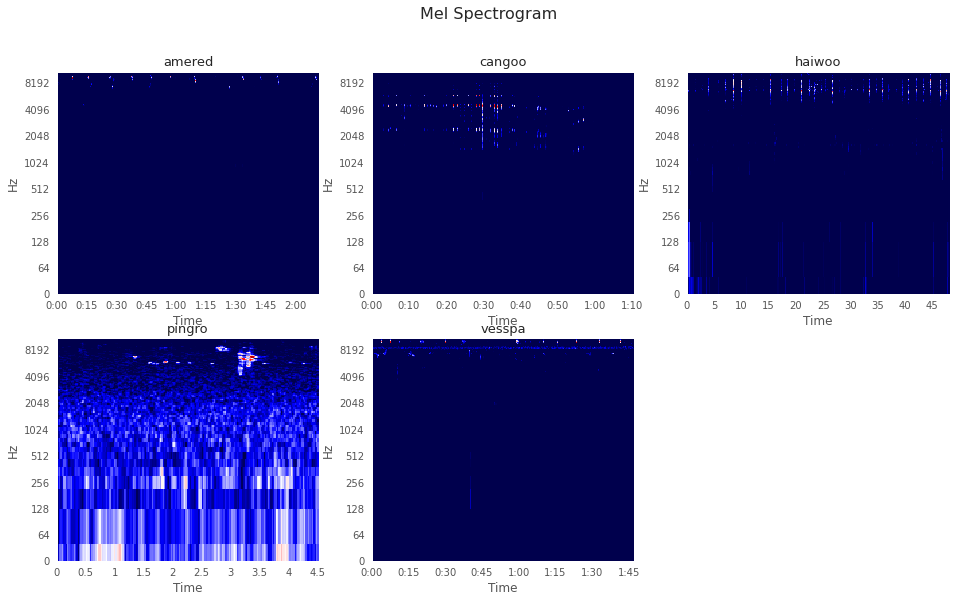

In [45]:
# Create the Mel Spectrograms
S_amered = librosa.feature.melspectrogram(y_amered, sr=sr_amered)
S_DB_amered = librosa.amplitude_to_db(S_amered, ref=np.max)

S_cangoo = librosa.feature.melspectrogram(y_cangoo, sr=sr_cangoo)
S_DB_cangoo = librosa.amplitude_to_db(S_cangoo, ref=np.max)

S_haiwoo = librosa.feature.melspectrogram(y_haiwoo, sr=sr_haiwoo)
S_DB_haiwoo = librosa.amplitude_to_db(S_haiwoo, ref=np.max)

S_pingro = librosa.feature.melspectrogram(y_pingro, sr=sr_pingro)
S_DB_pingro = librosa.amplitude_to_db(S_pingro, ref=np.max)

S_vesspa = librosa.feature.melspectrogram(y_vesspa, sr=sr_vesspa)
S_DB_vesspa = librosa.amplitude_to_db(S_vesspa, ref=np.max)

# === PLOT ====
fig, ax = plt.subplots(2, 3, figsize=(16, 9))
fig.suptitle('Mel Spectrogram', fontsize=16)
fig.delaxes(ax[1, 2])

librosa.display.specshow(S_DB_amered, sr = sr_amered, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'seismic', ax=ax[0, 0])
librosa.display.specshow(S_DB_cangoo, sr = sr_cangoo, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'seismic', ax=ax[0, 1])
librosa.display.specshow(S_DB_haiwoo, sr = sr_haiwoo, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'seismic', ax=ax[0, 2])
librosa.display.specshow(S_DB_pingro, sr = sr_pingro, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'seismic', ax=ax[1, 0])
librosa.display.specshow(S_DB_vesspa, sr = sr_vesspa, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'seismic', ax=ax[1, 1]);

for i, name in zip(range(0, 2*3), bird_sample_list):
    x = i // 3
    y = i % 3
    ax[x, y].set_title(name, fontsize=13)

### From above mel spectogram we can clearly see the difference of frequencies b/w different species

# Zero Crossing Rate: Transitions from positive to zero to negative or negative to zero to positive

In [46]:
# Total zero_crossings in our 1 song
zero_amered = librosa.zero_crossings(audio_amered, )
zero_cangoo = librosa.zero_crossings(audio_cangoo, )
zero_haiwoo = librosa.zero_crossings(audio_haiwoo, )
zero_pingro = librosa.zero_crossings(audio_pingro, )
zero_vesspa = librosa.zero_crossings(audio_vesspa, )

zero_birds_list = [zero_amered, zero_cangoo, zero_haiwoo, zero_pingro, zero_vesspa]

for bird, name in zip(zero_birds_list, bird_sample_list):
    print("{} change rate is {:,}".format(name, sum(bird)))

amered change rate is 1,243,905
cangoo change rate is 164,688
haiwoo change rate is 285,913
pingro change rate is 25,919
vesspa change rate is 1,125,467


### From above information we can see that amered and vesspa have high change rate from positive to zero to negative or negative to zero to positive

# Perceptual Correlate Of Waveform Periodicity

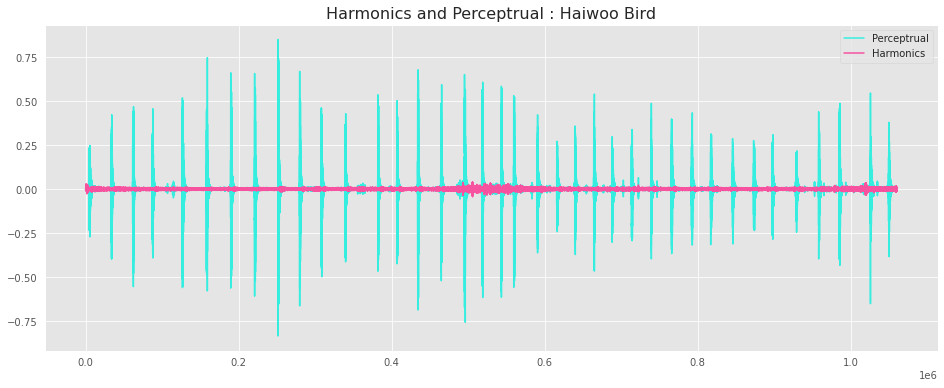

In [47]:
y_harm_haiwoo, y_perc_haiwoo = librosa.effects.hpss(audio_haiwoo)

plt.figure(figsize = (16, 6))
plt.plot(y_perc_haiwoo, color = '#36EEE0')
plt.plot(y_harm_haiwoo, color = '#F652A0')
plt.legend(("Perceptrual", "Harmonics"))
plt.title("Harmonics and Perceptrual : Haiwoo Bird", fontsize=16);

# RMSE: Signal energy, calculates the square root of the mean square

## Single Bird Voice Analysis

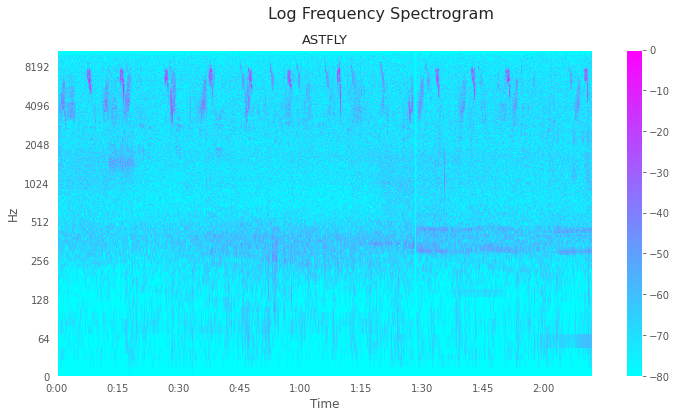

In [48]:
n_fft=2048
hop_length=512
# Short-time Fourier transform (STFT)
D_astfly = np.abs(librosa.stft(audio_amered, n_fft = n_fft, hop_length = hop_length))
# Convert an amplitude spectrogram to Decibels-scaled spectrogram.
DB_astfly = librosa.amplitude_to_db(D_astfly, ref = np.max)
# === PLOT ===
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
fig.suptitle('Log Frequency Spectrogram', fontsize=16)
# fig.delaxes(ax[1, 2])
img=librosa.display.specshow(DB_astfly, sr = sr_amered, hop_length = hop_length, x_axis = 'time', 
                         y_axis = 'log', cmap = 'cool', ax=ax)
ax.set_title('ASTFLY', fontsize=13) 
plt.colorbar(img,ax=ax)

### log frequency of bird astfly and noticed that the frequency range are from 4000 to 8000

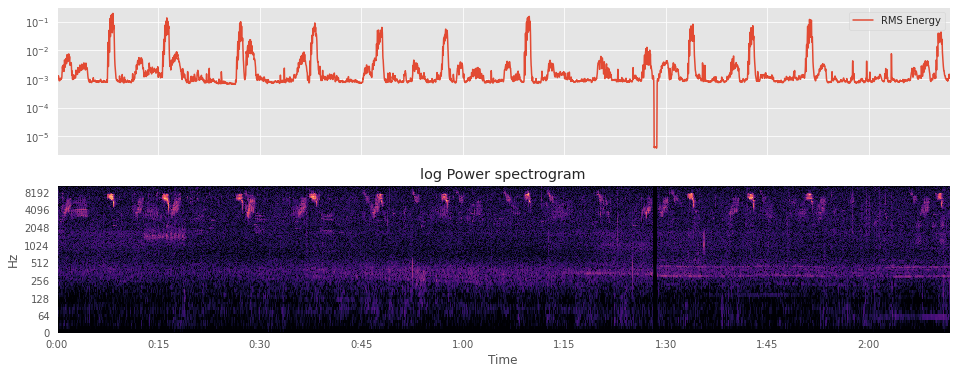

In [50]:
S, phase = librosa.magphase(librosa.stft(audio_amered))
S_db=librosa.amplitude_to_db(S, ref=np.max)
rms = librosa.feature.rms(S=S)
fig, ax = plt.subplots(nrows=2, sharex=True,figsize = (16, 6))
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(S_db,
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
plt.show()

### From above spectrogram, we can see the value range is from 0.001 to 0.1

### EDA Ended

# Model Implementation

## Duration and File Types torchlibrosa for audio file processing and features extraction


`torchlibrosa`, a PyTorch based implementation are used to replace some of the `librosa`'s functions. Here I use some functions of `torchlibrosa`.

If users previously used for training cpu-extracted features from librosa, but want to add GPU acceleration during training and evaluation, TorchLibrosa will provide almost identical features to standard torchlibrosa functions (numerical difference less than 1e-5)
Ref: https://github.com/qiuqiangkong/torchlibrosa

In [ ]:
class trainTBase(nn.Module):
    def __init__(self):
        """Base class for trainT and ItrainT matrix"""
        super(trainTBase, self).__init__()

    def traint_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(-2 * np.pi * 1j / n)
        W = np.power(omega, x * y)
        return W

    def itraint_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(2 * np.pi * 1j / n)
        W = np.power(omega, x * y)
        return W
    
    
class STFT(trainTBase):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, 
        window='hann', center=True, pad_mode='reflect', freeze_parameters=True):
        """Implementation of STFT with Conv1d. The function has the same output 
        of librosa.core.stft
        """
        super(STFT, self).__init__()

        assert pad_mode in ['constant', 'reflect']

        self.n_fft = n_fft
        self.center = center
        self.pad_mode = pad_mode

        # By default, use the entire frame
        if win_length is None:
            win_length = n_fft

        # Set the default hop, if it's not already specified
        if hop_length is None:
            hop_length = int(win_length // 4)

        fft_window = librosa.filters.get_window(window, win_length, fftbins=True)

        # Pad the window out to n_fft size
        fft_window = librosa.util.pad_center(fft_window, n_fft)

        # trainT & ItrainT matrix
        self.W = self.traint_matrix(n_fft)

        out_channels = n_fft // 2 + 1

        self.conv_real = nn.Conv1d(in_channels=1, out_channels=out_channels, 
            kernel_size=n_fft, stride=hop_length, padding=0, dilation=1, 
            groups=1, bias=False)

        self.conv_imag = nn.Conv1d(in_channels=1, out_channels=out_channels, 
            kernel_size=n_fft, stride=hop_length, padding=0, dilation=1, 
            groups=1, bias=False)

        self.conv_real.weight.data = torch.Tensor(
            np.real(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        self.conv_imag.weight.data = torch.Tensor(
            np.imag(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        """input: (batch_size, data_length)
        Returns:
          real: (batch_size, n_fft // 2 + 1, time_steps)
          imag: (batch_size, n_fft // 2 + 1, time_steps)
        """

        x = input[:, None, :]   # (batch_size, channels_num, data_length)

        if self.center:
            x = F.pad(x, pad=(self.n_fft // 2, self.n_fft // 2), mode=self.pad_mode)

        real = self.conv_real(x)
        imag = self.conv_imag(x)
        # (batch_size, n_fft // 2 + 1, time_steps)

        real = real[:, None, :, :].transpose(2, 3)
        imag = imag[:, None, :, :].transpose(2, 3)
        # (batch_size, 1, time_steps, n_fft // 2 + 1)

        return real, imag
    
    
class Spectrogram(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None, 
        window='hann', center=True, pad_mode='reflect', power=2.0, 
        freeze_parameters=True):
        """Calculate spectrogram using pytorch. The STFT is implemented with 
        Conv1d. The function has the same output of librosa.core.stft
        """
        super(Spectrogram, self).__init__()

        self.power = power

        self.stft = STFT(n_fft=n_fft, hop_length=hop_length, 
            win_length=win_length, window=window, center=center, 
            pad_mode=pad_mode, freeze_parameters=True)

    def forward(self, input):
        """input: (batch_size, 1, time_steps, n_fft // 2 + 1)
        Returns:
          spectrogram: (batch_size, 1, time_steps, n_fft // 2 + 1)
        """

        (real, imag) = self.stft.forward(input)
        # (batch_size, n_fft // 2 + 1, time_steps)

        spectrogram = real ** 2 + imag ** 2

        if self.power == 2.0:
            pass
        else:
            spectrogram = spectrogram ** (power / 2.0)

        return spectrogram

    
class LogmelFilterBank(nn.Module):
    def __init__(self, sr=32000, n_fft=2048, n_mels=64, fmin=50, fmax=14000, is_log=True, 
        ref=1.0, amin=1e-10, top_db=80.0, freeze_parameters=True):
        """Calculate logmel spectrogram using pytorch. The mel filter bank is 
        the pytorch implementation of as librosa.filters.mel 
        """
        super(LogmelFilterBank, self).__init__()

        self.is_log = is_log
        self.ref = ref
        self.amin = amin
        self.top_db = top_db

        self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,
            fmin=fmin, fmax=fmax).T
        # (n_fft // 2 + 1, mel_bins)

        self.melW = nn.Parameter(torch.Tensor(self.melW))

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        """input: (batch_size, channels, time_steps)
        
        Output: (batch_size, time_steps, mel_bins)
        """

        # Mel spectrogram
        mel_spectrogram = torch.matmul(input, self.melW)

        # Logmel spectrogram
        if self.is_log:
            output = self.power_to_db(mel_spectrogram)
        else:
            output = mel_spectrogram

        return output


    def power_to_db(self, input):
        """Power to db, this function is the pytorch implementation of 
        librosa.core.power_to_lb
        """
        ref_value = self.ref
        log_spec = 10.0 * torch.log10(torch.clamp(input, min=self.amin, max=np.inf))
        log_spec -= 10.0 * np.log10(np.maximum(self.amin, ref_value))

        if self.top_db is not None:
            if self.top_db < 0:
                raise ParameterError('top_db must be non-negative')
            log_spec = torch.clamp(log_spec, min=log_spec.max().item() - self.top_db, max=np.inf)

        return log_spec

In [ ]:
class DropStripes(nn.Module):
    def __init__(self, dim, drop_width, stripes_num):
        """Drop stripes. 
        Args:
          dim: int, dimension along which to drop
          drop_width: int, maximum width of stripes to drop
          stripes_num: int, how many stripes to drop
        """
        super(DropStripes, self).__init__()

        assert dim in [2, 3]    # dim 2: time; dim 3: frequency

        self.dim = dim
        self.drop_width = drop_width
        self.stripes_num = stripes_num

    def forward(self, input):
        """input: (batch_size, channels, time_steps, freq_bins)"""

        assert input.ndimension() == 4

        if self.training is False:
            return input

        else:
            batch_size = input.shape[0]
            total_width = input.shape[self.dim]

            for n in range(batch_size):
                self.transform_slice(input[n], total_width)

            return input


    def transform_slice(self, e, total_width):
        """e: (channels, time_steps, freq_bins)"""

        for _ in range(self.stripes_num):
            distance = torch.randint(low=0, high=self.drop_width, size=(1,))[0]
            bgn = torch.randint(low=0, high=total_width - distance, size=(1,))[0]

            if self.dim == 2:
                e[:, bgn : bgn + distance, :] = 0
            elif self.dim == 3:
                e[:, :, bgn : bgn + distance] = 0


class SpecAugmentation(nn.Module):
    def __init__(self, time_drop_width, time_stripes_num, freq_drop_width, 
        freq_stripes_num):
        """Spec augmetation. 
        [ref] Park, D.S., Chan, W., Zhang, Y., Chiu, C.C., Zoph, B., Cubuk, E.D. 
        and Le, Q.V., 2019. Specaugment: A simple data augmentation method 
        for automatic speech recognition. arXiv preprint arXiv:1904.08779.
        Args:
          time_drop_width: int
          time_stripes_num: int
          freq_drop_width: int
          freq_stripes_num: int
        """

        super(SpecAugmentation, self).__init__()

        self.time_dropper = DropStripes(dim=2, drop_width=time_drop_width, 
            stripes_num=time_stripes_num)

        self.freq_dropper = DropStripes(dim=3, drop_width=freq_drop_width, 
            stripes_num=freq_stripes_num)

    def forward(self, input):
        x = self.time_dropper(input)
        x = self.freq_dropper(x)
        return x

### Audioset Tagging CNN

We also use `Cnn14_DecisionLevelAtt` model from [Models models], which is a SED model.

### Building blocks

In [ ]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.

    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    pad = framewise_output[:, -1:, :].repeat(
        1, frames_num - framewise_output.shape[1], 1)
    """tensor for padding"""

    output = torch.cat((framewise_output, pad), dim=1)
    """(batch_size, frames_num, classes_num)"""

    return output


class ConvBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
            bias=False)

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()

    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

    def forward(self, input, pool_size=(2, 2), pool_type='avg'):

        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')

        return x


class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

In [ ]:
class MASK_RCNN(nn.Module):
    def __init__(self, sample_rate: int, window_size: int, hop_size: int,
                 mel_bins: int, fmin: int, fmax: int, classes_num: int):
        super().__init__()

        window = 'hann'
        center = True
        pad_mode = 'reflect'
        ref = 1.0
        amin = 1e-10
        top_db = None
        self.interpolate_ratio = 32  # Downsampled ratio

        # Spectrogram extractor
        self.spectrogram_extractor = Spectrogram(
            n_fft=window_size,
            hop_length=hop_size,
            win_length=window_size,
            window=window,
            center=center,
            pad_mode=pad_mode,
            freeze_parameters=True)

        # Logmel feature extractor
        self.logmel_extractor = LogmelFilterBank(
            sr=sample_rate,
            n_fft=window_size,
            n_mels=mel_bins,
            fmin=fmin,
            fmax=fmax,
            ref=ref,
            amin=amin,
            top_db=top_db,
            freeze_parameters=True)

        # Spec augmenter
        self.spec_augmenter = SpecAugmentation(
            time_drop_width=64,
            time_stripes_num=2,
            freq_drop_width=8,
            freq_stripes_num=2)

        self.bn0 = nn.BatchNorm2d(mel_bins)

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)
        self.conv_block5 = ConvBlock(in_channels=512, out_channels=1024)
        self.conv_block6 = ConvBlock(in_channels=1024, out_channels=2048)

        self.fc1 = nn.Linear(2048, 2048, bias=True)
        self.att_block = AttBlock(2048, classes_num, activation='sigmoid')

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
        
    def cnn_feature_extractor(self, x):
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        return x
    
    def preprocess(self, input, mixup_lambda=None):
        # t1 = time.time()
        x = self.spectrogram_extractor(input)  # (batch_size, 1, time_steps, freq_bins)
        x = self.logmel_extractor(x)  # (batch_size, 1, time_steps, mel_bins)

        frames_num = x.shape[2]

        x = x.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        if self.training:
            x = self.spec_augmenter(x)

        # Mixup on spectrogram
        if self.training and mixup_lambda is not None:
            x = do_mixup(x, mixup_lambda)
        return x, frames_num
        

    def forward(self, input, mixup_lambda=None):
        """
        Input: (batch_size, data_length)"""
        x, frames_num = self.preprocess(input, mixup_lambda=mixup_lambda)

        # Output shape (batch size, channels, time, frequency)
        x = self.cnn_feature_extractor(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=3)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu_(self.fc1(x))
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.5, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)
        segmentwise_output = segmentwise_output.transpose(1, 2)

        # Get framewise output
        framewise_output = interpolate(segmentwise_output,
                                       self.interpolate_ratio)
        framewise_output = pad_framewise_output(framewise_output, frames_num)

        output_dict = {
            'framewise_output': framewise_output,
            'clipwise_output': clipwise_output
        }

        return output_dict

What is good in MASK RCNN models is that they accept raw audio clip as input. Let's put a chunk into the CNN feature extractor of the model above.

In [ ]:
train_resample_audio_dir

In [ ]:
SR = 32000

y, _ = librosa.load(train_resample_audio_dir[0] / "aldfly" / "XC134874.wav",
                    sr=SR,
                    res_type="kaiser_fast",
                    mono=True)

Audio(y, rate=SR)

In [ ]:
display.waveplot(y, sr=SR);

In [ ]:
model_config = {
    "sample_rate": 32000,
    "window_size": 1024,
    "hop_size": 320,
    "mel_bins": 64,
    "fmin": 50,
    "fmax": 14000,
    "classes_num": 264
}

model = MASK_RCNN(**model_config)

In `MASK_RCNN`, input raw waveform will be converted into log-melspectrogram using `torchlibrosa`'s utilities. I put this functionality in `MASK_RCNN.preprocess()` method. Let's check the output.

In [ ]:
chunk = torch.from_numpy(y[:SR * 5]).unsqueeze(0)
melspec, _ = model.preprocess(chunk)
melspec.size()

In [ ]:
melspec_numpy = melspec.detach().numpy()[0, 0].transpose(1, 0)
display.specshow(melspec_numpy, sr=SR, y_axis="mel");

`MASK_RCNN.cnn_feature_extractor()` method will take this as input and output feature map. Let's check the output of the feature extractor.

In [ ]:
feature_map = model.cnn_feature_extractor(melspec)
feature_map.size()

Although it's downsized through several convolution and pooling layers, the size of it's third dimension is 15 and it still contains time information. Each element of this dimension is *segment*. In SED model, we provide prediction for each of this.

## Train SED model with only weak supervision

![weak-label-vs-strong-label](https://www.researchgate.net/profile/Anurag_Kumar10/publication/329239818/figure/fig5/AS:743089203322880@1554177680169/Weakly-Labeled-vs-Strongly-Labeled-Strongly-labeled-data-contains-time-stamps-of-the.ppm)

<br/>

This figure gives us an intuitive explanation what is *weak annotation* and what is *strong annotation* in terms of sound event detection. For this competition, we only have weak annotation (clip level annotation). Therefore, we need to train our SED model in weakly-supervised manner.

In weakly-supervised setting, we only have clip-level annotation, therefore we also need to aggregate that in time axis. Hense, we at first put classifier that outputs class existence probability for each time step just after the feature extractor and then aggregate the output of the classifier result in time axis.
In this way we can get both clip-level prediction and segment-level prediction (if the time resolution is high, it can be treated as event-level prediction). Then we train it normally by using BCE loss with clip-level prediction and clip-level annotation.

Let's check how this is implemented in the PANNs model above. segment-wise prediction and clip-wise prediction is actually calculated in `AttBlock` of the model.

```
class AttBlock(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear",
                 temperature=1.0):
        super().__init__()

        self.activation = activation
        self.temperature = temperature
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.bn_att = nn.BatchNorm1d(out_features)
        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)
        init_bn(self.bn_att)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)
```

In the `forward` method, it at first calculate self-attention map in the first line `norm_att = torch.softmax(torch.clamp(self.att(x), -10, 10), dim=-1)`. This will be used to aggregate the classification result for segment. In the second line, `cla = self.nonlinear_transform(self.cla(x))` calculates segment wise classification result. Then in the third line, attention aggregation is performed to get clip wise prediction.

Now, let's try to train this model in weakly-supervised manner.

### Dataset

In [ ]:
BIRD_CODE = {
    'altrainly': 0, 'ameavo': 1, 'amebit': 2, 'amecro': 3, 'amegfi': 4,
    'amekes': 5, 'amepip': 6, 'amered': 7, 'amerob': 8, 'amewig': 9,
    'amewoo': 10, 'amtspa': 11, 'annhum': 12, 'astfly': 13, 'baisan': 14,
    'baleag': 15, 'balori': 16, 'banswa': 17, 'barswa': 18, 'bawwar': 19,
    'belkin1': 20, 'belspa2': 21, 'bewwre': 22, 'bkbcuc': 23, 'bkbmag1': 24,
    'bkbwar': 25, 'bkcchi': 26, 'bkchum': 27, 'bkhgro': 28, 'bkpwar': 29,
    'bktspa': 30, 'blkpho': 31, 'blugrb1': 32, 'blujay': 33, 'bnhcow': 34,
    'boboli': 35, 'bongul': 36, 'brdowl': 37, 'brebla': 38, 'brespa': 39,
    'brncre': 40, 'brnthr': 41, 'brthum': 42, 'brwhaw': 43, 'btbwar': 44,
    'btnwar': 45, 'btywar': 46, 'buffle': 47, 'buggna': 48, 'buhvir': 49,
    'bulori': 50, 'bushti': 51, 'buwtea': 52, 'buwwar': 53, 'cacwre': 54,
    'calgul': 55, 'calqua': 56, 'camwar': 57, 'cangoo': 58, 'canwar': 59,
    'canwre': 60, 'carwre': 61, 'casfin': 62, 'caster1': 63, 'casvir': 64,
    'cedwax': 65, 'chispa': 66, 'chiswi': 67, 'chswar': 68, 'chukar': 69,
    'clanut': 70, 'cliswa': 71, 'comgol': 72, 'comgra': 73, 'comloo': 74,
    'commer': 75, 'comnig': 76, 'comrav': 77, 'comred': 78, 'comter': 79,
    'comyel': 80, 'coohaw': 81, 'coshum': 82, 'cowscj1': 83, 'daejun': 84,
    'doccor': 85, 'dowwoo': 86, 'dusfly': 87, 'eargre': 88, 'easblu': 89,
    'easkin': 90, 'easmea': 91, 'easpho': 92, 'eastow': 93, 'eawpew': 94,
    'eucdov': 95, 'eursta': 96, 'evegro': 97, 'fiespa': 98, 'fiscro': 99,
    'foxspa': 100, 'gadwal': 101, 'gcrfin': 102, 'gnttow': 103, 'gnwtea': 104,
    'gockin': 105, 'gocspa': 106, 'goleag': 107, 'grbher3': 108, 'grcfly': 109,
    'greegr': 110, 'greroa': 111, 'greyel': 112, 'grhowl': 113, 'grnher': 114,
    'grtgra': 115, 'grycat': 116, 'gryfly': 117, 'haiwoo': 118, 'hamfly': 119,
    'hergul': 120, 'herthr': 121, 'hoomer': 122, 'hoowar': 123, 'horgre': 124,
    'horlar': 125, 'houfin': 126, 'houspa': 127, 'houwre': 128, 'indbun': 129,
    'juntit1': 130, 'killde': 131, 'labwoo': 132, 'larspa': 133, 'lazbun': 134,
    'leabit': 135, 'leafly': 136, 'leasan': 137, 'lecthr': 138, 'lesgol': 139,
    'lesnig': 140, 'lesyel': 141, 'lewwoo': 142, 'linspa': 143, 'lobcur': 144,
    'lobdow': 145, 'logshr': 146, 'lotduc': 147, 'louwat': 148, 'macwar': 149,
    'magwar': 150, 'mallar3': 151, 'marwre': 152, 'merlin': 153, 'moublu': 154,
    'mouchi': 155, 'moudov': 156, 'norcar': 157, 'norfli': 158, 'norhar2': 159,
    'normoc': 160, 'norpar': 161, 'norpin': 162, 'norsho': 163, 'norwat': 164,
    'nrwswa': 165, 'nutwoo': 166, 'olsfly': 167, 'orcwar': 168, 'osprey': 169,
    'ovenbi1': 170, 'palwar': 171, 'pasfly': 172, 'pecsan': 173, 'perfal': 174,
    'phaino': 175, 'pibgre': 176, 'pilwoo': 177, 'pingro': 178, 'pinjay': 179,
    'pinsis': 180, 'pinwar': 181, 'plsvir': 182, 'prawar': 183, 'purfin': 184,
    'pygnut': 185, 'rebmer': 186, 'rebnut': 187, 'rebsap': 188, 'rebwoo': 189,
    'redcro': 190, 'redhea': 191, 'reevir1': 192, 'renpha': 193, 'reshaw': 194,
    'rethaw': 195, 'rewbla': 196, 'ribgul': 197, 'rinduc': 198, 'robgro': 199,
    'rocpig': 200, 'rocwre': 201, 'rthhum': 202, 'ruckin': 203, 'rudduc': 204,
    'rufgro': 205, 'rufhum': 206, 'rusbla': 207, 'sagspa1': 208, 'sagthr': 209,
    'savspa': 210, 'saypho': 211, 'scatan': 212, 'scoori': 213, 'semplo': 214,
    'semsan': 215, 'sheowl': 216, 'shshaw': 217, 'snobun': 218, 'snogoo': 219,
    'solsan': 220, 'sonspa': 221, 'sora': 222, 'sposan': 223, 'spotow': 224,
    'stejay': 225, 'swahaw': 226, 'swaspa': 227, 'swathr': 228, 'treswa': 229,
    'truswa': 230, 'tuftit': 231, 'tunswa': 232, 'veery': 233, 'vesspa': 234,
    'vigswa': 235, 'warvir': 236, 'wesblu': 237, 'wesgre': 238, 'weskin': 239,
    'wesmea': 240, 'wessan': 241, 'westan': 242, 'wewpew': 243, 'whbnut': 244,
    'whcspa': 245, 'whfibi': 246, 'whtspa': 247, 'whtswi': 248, 'wilfly': 249,
    'wilsni1': 250, 'wiltur': 251, 'winwre3': 252, 'wlswar': 253, 'wooduc': 254,
    'wooscj2': 255, 'woothr': 256, 'y00475': 257, 'yebfly': 258, 'yebsap': 259,
    'yehbla': 260, 'yelwar': 261, 'yerwar': 262, 'yetvir': 263
}

INV_BIRD_CODE = {v: k for k, v in BIRD_CODE.items()}

In [ ]:
PERIOD = 5

class PANNsDataset(data.Dataset):
    def __init__(
            self,
            file_list: List[List[str]],
            waveform_transforms=None):
        self.file_list = file_list  # list of list: [file_path, ebird_code]
        self.waveform_transforms = waveform_transforms

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx: int):
        wav_path, ebird_code = self.file_list[idx]

        y, sr = sf.read(wav_path)

        if self.waveform_transforms:
            y = self.waveform_transforms(y)
        else:
            len_y = len(y)
            effective_length = sr * PERIOD
            if len_y < effective_length:
                new_y = np.zeros(effective_length, dtype=y.dtype)
                start = np.random.randint(effective_length - len_y)
                new_y[start:start + len_y] = y
                y = new_y.astype(np.float32)
            elif len_y > effective_length:
                start = np.random.randint(len_y - effective_length)
                y = y[start:start + effective_length].astype(np.float32)
            else:
                y = y.astype(np.float32)

        labels = np.zeros(len(BIRD_CODE), dtype="f")
#         print(labels)
        labels[BIRD_CODE[ebird_code]] = 1

        return {"waveform": y, "targets": labels}

### Criterion

In [ ]:
class PANNsLoss(nn.Module):
    def __init__(self):
        super().__init__()

        self.bce = nn.BCELoss()

    def forward(self, input, target):
        input_ = input["clipwise_output"]
        input_ = torch.where(torch.isnan(input_),
                             torch.zeros_like(input_),
                             input_)
        input_ = torch.where(torch.isinf(input_),
                             torch.zeros_like(input_),
                             input_)

        target = target.float()

        return self.bce(input_, target)

### Callbacks

In [ ]:
class F1Callback(Callback):
    def __init__(self,
                 input_key: str = "targets",
                 output_key: str = "logits",
                 model_output_key: str = "clipwise_output",
                 prefix: str = "f1"):
        super().__init__(CallbackOrder.Metric)

        self.input_key = input_key
        self.output_key = output_key
        self.model_output_key = model_output_key
        self.prefix = prefix

    def on_loader_start(self, state: State):
        self.prediction: List[np.ndarray] = []
        self.target: List[np.ndarray] = []

    def on_batch_end(self, state: State):
        targ = state.input[self.input_key].detach().cpu().numpy()
        out = state.output[self.output_key]

        clipwise_output = out[self.model_output_key].detach().cpu().numpy()

        self.prediction.append(clipwise_output)
        self.target.append(targ)

        y_pred = clipwise_output.argmax(axis=1)
        y_true = targ.argmax(axis=1)

        score = f1_score(y_true, y_pred, average="macro")
        state.batch_metrics[self.prefix] = score

    def on_loader_end(self, state: State):
        y_pred = np.concatenate(self.prediction, axis=0).argmax(axis=1)
        y_true = np.concatenate(self.target, axis=0).argmax(axis=1)
        score = f1_score(y_true, y_pred, average="macro")
        state.loader_metrics[self.prefix] = score
        if state.is_valid_loader:
            state.epoch_metrics[state.valid_loader + "_epoch_" +
                                self.prefix] = score
        else:
            state.epoch_metrics["train_epoch_" + self.prefix] = score


class mAPCallback(Callback):
    def __init__(self,
                 input_key: str = "targets",
                 output_key: str = "logits",
                 model_output_key: str = "clipwise_output",
                 prefix: str = "mAP"):
        super().__init__(CallbackOrder.Metric)
        self.input_key = input_key
        self.output_key = output_key
        self.model_output_key = model_output_key
        self.prefix = prefix

    def on_loader_start(self, state: State):
        self.prediction: List[np.ndarray] = []
        self.target: List[np.ndarray] = []

    def on_batch_end(self, state: State):
        targ = state.input[self.input_key].detach().cpu().numpy()
        out = state.output[self.output_key]

        clipwise_output = out[self.model_output_key].detach().cpu().numpy()

        self.prediction.append(clipwise_output)
        self.target.append(targ)

        score = average_precision_score(targ, clipwise_output, average=None)
        score = np.nan_to_num(score).mean()
        state.batch_metrics[self.prefix] = score

    def on_loader_end(self, state: State):
        y_pred = np.concatenate(self.prediction, axis=0)
        y_true = np.concatenate(self.target, axis=0)
        score = average_precision_score(y_true, y_pred, average=None)
        score = np.nan_to_num(score).mean()
        state.loader_metrics[self.prefix] = score
        if state.is_valid_loader:
            state.epoch_metrics[state.valid_loader + "_epoch_" +
                                self.prefix] = score
        else:
            state.epoch_metrics["train_epoch_" + self.prefix] = score

### Train

Some code are taken from https://www.kaggle.com/ttahara/training-birdsong-baseline-resnest50-fast .
Thanks @ttahara!

In [ ]:
tmp_list = []
for audio_d in train_resample_audio_dir:
    if not audio_d.exists():
        continue
    for ebird_d in audio_d.iterdir():
        if ebird_d.is_file():
            continue
        for wav_f in ebird_d.iterdir():
            tmp_list.append([ebird_d.name, wav_f.name, wav_f.as_posix()])
            
train_wav_path_exist = pd.DataFrame(
    tmp_list, columns=["ebird_code", "resampled_filename", "file_path"])

del tmp_list

train_all = pd.merge(
    train, train_wav_path_exist, on=["ebird_code", "resampled_filename"], how="inner")

print(train.shape)
print(train_wav_path_exist.shape)
print(train_all.shape)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

train_all["fold"] = -1
for fold_id, (train_index, val_index) in enumerate(skf.split(train_all, train_all["ebird_code"])):
    train_all.iloc[val_index, -1] = fold_id
    
# # check the propotion
fold_proportion = pd.pivot_table(train_all, index="ebird_code", columns="fold", values="xc_id", aggfunc=len)
print(fold_proportion.shape)

In [ ]:
use_fold = 0
train_file_list = train_all.query("fold != @use_fold")[["file_path", "ebird_code"]].values.tolist()
val_file_list = train_all.query("fold == @use_fold")[["file_path", "ebird_code"]].values.tolist()

print("[fold {}] train: {}, val: {}".format(use_fold, len(train_file_list), len(val_file_list)))

In [ ]:
# device = torch.device("cuda:0")

# # loaders
# loaders = {
#     "train": data.DataLoader(PANNsDataset(train_file_list, None), 
#                              batch_size=64, 
#                              shuffle=True, 
#                              num_workers=2, 
#                              pin_memory=True, 
#                              drop_last=True),
#     "valid": data.DataLoader(PANNsDataset(val_file_list, None), 
#                              batch_size=64, 
#                              shuffle=False,
#                              num_workers=2,
#                              pin_memory=True,
#                              drop_last=False)
# }


In [ ]:
## device = torch.device("cuda:0")

# loaders
loaders = {
    "train": data.DataLoader(PANNsDataset(train_file_list, None), 
                             batch_size=64, 
                             shuffle=True, 
                             num_workers=2, 
                             pin_memory=True, 
                             drop_last=True),
    "valid": data.DataLoader(PANNsDataset(val_file_list, None), 
                             batch_size=64, 
                             shuffle=False,
                             num_workers=2,
                             pin_memory=True,
                             drop_last=False)
}

# model
model_config["classes_num"] = 264
model = MASK_RCNN(**model_config)
weights = torch.load("model/Cnn14_DecisionLevelAtt_mAP0.425.pth")
# Fixed in V3
model.load_state_dict(weights["model"])
model.att_block = AttBlock(2048, 264, activation='sigmoid')
model.att_block.init_weights()
model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Loss
criterion = PANNsLoss().to(device)

# callbacks
callbacks = [
    F1Callback(input_key="targets", output_key="logits", prefix="f1"),
    mAPCallback(input_key="targets", output_key="logits", prefix="mAP"),
    CheckpointCallback(save_n_best=0)
]

In [ ]:
labels[BIRD_CODE[ebird_code]]

In [ ]:
warnings.simplefilter("ignore")

runner = SupervisedRunner(
    device=device,
    input_key="waveform",
    input_target_key="targets")

runner.train(
    model=model,
    criterion=criterion,
    loaders=loaders,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=10,
    verbose=True,
    logdir=f"fold0",
    callbacks=callbacks,
    main_metric="epoch_f1",
    minimize_metric=False)

Seems it's learning something.

Now I'll show how this model works in the inference phase. I'll use trained model of this which I trained by myself using the data of this competition in my local environment.

Since [several concerns](https://www.kaggle.com/c/birdsong-recognition/discussion/172356) are expressed about over-sharing of top solutions during competition, and since I do respect those people who have worked hard to improve their scores, I would not make trained weight in common and would not share how I trained this model.

## Prediction with SED model

In [ ]:
model_config = {
    "sample_rate": 32000,
    "window_size": 1024,
    "hop_size": 320,
    "mel_bins": 64,
    "fmin": 50,
    "fmax": 14000,
    "classes_num": 264
}

weights_path = "model/best.pth"

In [ ]:
def get_model(config: dict, weights_path: str):
    model = MASK_RCNN(**config)
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    device = torch.device("cuda")
    model.to(device)
    model.eval()
    return model

In [ ]:
def prediction_for_clip(test_train: pd.DataFrame,
                        clip: np.ndarray, 
                        model: MASK_RCNN,
                        threshold=0.5):
    PERIOD = 30
    audios = []
    y = clip.astype(np.float32)
    len_y = len(y)
    start = 0
    end = PERIOD * SR
    while True:
        y_batch = y[start:end].astype(np.float32)
        if len(y_batch) != PERIOD * SR:
            y_pad = np.zeros(PERIOD * SR, dtype=np.float32)
            y_pad[:len(y_batch)] = y_batch
            audios.append(y_pad)
            break
        start = end
        end += PERIOD * SR
        audios.append(y_batch)
        
    array = np.asarray(audios)
    tensors = torch.from_numpy(array)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    estimated_event_list = []
    global_time = 0.0
    site = test_train["site"].values[0]
    audio_id = test_train["audio_id"].values[0]
    for image in progress_bar(tensors):
        image = image.view(1, image.size(0))
        image = image.to(device)

        with torch.no_grad():
            prediction = model(image)
            framewise_outputs = prediction["framewise_output"].detach(
                ).cpu().numpy()[0]
                
        thresholded = framewise_outputs >= threshold

        for target_idx in range(thresholded.shape[1]):
            if thresholded[:, target_idx].mean() == 0:
                pass
            else:
                detected = np.argwhere(thresholded[:, target_idx]).reshape(-1)
                head_idx = 0
                tail_idx = 0
                while True:
                    if (tail_idx + 1 == len(detected)) or (
                            detected[tail_idx + 1] - 
                            detected[tail_idx] != 1):
                        onset = 0.01 * detected[
                            head_idx] + global_time
                        offset = 0.01 * detected[
                            tail_idx] + global_time
                        onset_idx = detected[head_idx]
                        offset_idx = detected[tail_idx]
                        max_confidence = framewise_outputs[
                            onset_idx:offset_idx, target_idx].max()
                        mean_confidence = framewise_outputs[
                            onset_idx:offset_idx, target_idx].mean()
                        estimated_event = {
                            "site": site,
                            "audio_id": audio_id,
                            "ebird_code": INV_BIRD_CODE[target_idx],
                            "onset": onset,
                            "offset": offset,
                            "max_confidence": max_confidence,
                            "mean_confidence": mean_confidence
                        }
                        estimated_event_list.append(estimated_event)
                        head_idx = tail_idx + 1
                        tail_idx = tail_idx + 1
                        if head_idx >= len(detected):
                            break
                    else:
                        tail_idx += 1
        global_time += PERIOD
        
    prediction_train = pd.DataFrame(estimated_event_list)
    return prediction_train

In [ ]:
def prediction(test_train: pd.DataFrame,
               test_audio: Path,
               model_config: dict,
               weights_path: str,
               threshold=0.5):
    model = get_model(model_config, weights_path)
    unique_audio_id = test_train.audio_id.unique()

    warnings.filterwarnings("ignore")
    prediction_trains = []
    for audio_id in unique_audio_id:
        with timer(f"Loading {audio_id}"):
            clip, _ = librosa.load(test_audio / (audio_id + ".mp3"),
                                   sr=SR,
                                   mono=True,
                                   res_type="kaiser_fast")
        
        test_train_for_audio_id = test_train.query(
            f"audio_id == '{audio_id}'").reset_index(drop=True)
        with timer(f"Prediction on {audio_id}"):
            prediction_train = prediction_for_clip(test_train_for_audio_id,
                                                clip=clip,
                                                model=model,
                                                threshold=threshold)

        prediction_trains.append(prediction_train)
    
    prediction_train = pd.concat(prediction_trains, axis=0, sort=False).reset_index(drop=True)
    return prediction_train

In [ ]:
prediction_train = prediction(test_train=test,
                           test_audio=test_dir,
                           model_config=model_config,
                           weights_path=weights_path,
                           threshold=0.5)

In [ ]:
prediction_train

## Postprocess


In [ ]:
labels = {}

for audio_id, sub_train in prediction_train.groupby("audio_id"):
    events = sub_train[["ebird_code", "onset", "offset", "max_confidence", "site"]].values
    n_events = len(events)
    removed_event = []
    # Overlap deletion: this part may not be necessary
    # I deleted this part in other model and found there's no difference on the public LB score.
    for i in range(n_events):
        for j in range(n_events):
            if i == j:
                continue
            if i in removed_event:
                continue
            if j in removed_event:
                continue
            
            event_i = events[i]
            event_j = events[j]
            
            if (event_i[1] - event_j[2] >= 0) or (event_j[1] - event_i[2] >= 0):
                pass
            else:
                later_onset = max(event_i[1], event_j[1])
                sooner_onset = min(event_i[1], event_j[1])
                sooner_offset = min(event_i[2], event_j[2])
                later_offset = max(event_i[2], event_j[2])

                intersection = sooner_offset - later_onset
                union = later_offset - sooner_onset
                
                iou = intersection / union
                if iou > 0.4:
                    if event_i[3] > event_j[3]:
                        removed_event.append(j)
                    else:
                        removed_event.append(i)

    site = events[0][4]
    for i in range(n_events):
        if i in removed_event:
            continue
        event = events[i][0]
        onset = events[i][1]
        offset = events[i][2]
        if site in {"site_1", "site_2"}:
            start_section = int((onset // 5) * 5) + 5
            end_section = int((offset // 5) * 5) + 5
            cur_section = start_section

            row_id = f"{site}_{audio_id}_{start_section}"
            if labels.get(row_id) is not None:
                labels[row_id].add(event)
            else:
                labels[row_id] = set()
                labels[row_id].add(event)

            while cur_section != end_section:
                cur_section += 5
                row_id = f"{site}_{audio_id}_{cur_section}"
                if labels.get(row_id) is not None:
                    labels[row_id].add(event)
                else:
                    labels[row_id] = set()
                    labels[row_id].add(event)
        else:
            row_id = f"{site}_{audio_id}"
            if labels.get(row_id) is not None:
                labels[row_id].add(event)
            else:
                labels[row_id] = set()
                labels[row_id].add(event)

In [ ]:
for key in labels:
    labels[key] = " ".join(sorted(list(labels[key])))
    
    
row_ids = list(labels.keys())
birds = list(labels.values())
post_processed = pd.DataFrame({
    "row_id": row_ids,
    "birds": birds
})
post_processed.head()

In [ ]:
all_row_id = test[["row_id"]]
submission = all_row_id.merge(post_processed, on="row_id", how="left")
submission = submission.fillna("nocall")
submission.to_csv("submission.csv", index=False)
submission.head(20)

## EOF